In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
df=pd.read_excel("dataIndia.xlsx")
df.Date=pd.to_datetime(df.Date,infer_datetime_format=True)
State_name="all"
df

,Date,State/UnionTerritory,Cured,Deaths,Confirmed
0,2020-01-30,Kerala,0,0,1
1,2020-01-31,Kerala,0,0,1
2,2020-02-01,Kerala,0,0,2
3,2020-02-02,Kerala,0,0,3
4,2020-02-03,Kerala,0,0,3
...,...,...,...,...,...
5856,2020-09-02,Telengana,97402,846,130589
5857,2020-09-02,Tripura,7847,118,12702
5858,2020-09-02,Uttarakhand,14076,280,20398
5859,2020-09-02,Uttar Pradesh,176677,3542,235757


### Creating Data Frame with Confirmed and Cured lags

In [54]:
if State_name=="all":
    df_State=pd.DataFrame((df.groupby('Date')['Deaths','Confirmed','Cured'].sum()))
    df_State.reset_index(inplace = True)
else:
    df_State=df[df['State/UnionTerritory']==State_name]


df_out={'Date': df_State.Date.to_list(),
             'Deaths':df_State.Deaths.to_list(),
            'ConLag14':df_State.Confirmed.shift(14).to_list(),
            'CurLag14':df_State.Cured.shift(14).to_list()
           }

df_out=pd.DataFrame(df_out)
df_out.columns
df_out=df_out.dropna()
df_out.set_index('Date',inplace=True)
for cols in df_out.columns:
    if cols=="Date":
        continue
    else:
        df_out[cols]=df_out[cols].astype(int)

In [55]:
df_State

,Date,Deaths,Confirmed,Cured
0,2020-01-30,0,1,0
1,2020-01-31,0,1,0
2,2020-02-01,0,2,0
3,2020-02-02,0,3,0
4,2020-02-03,0,3,0
...,...,...,...,...
212,2020-08-29,62550,3463972,2648998
213,2020-08-30,63498,3542733,2713933
214,2020-08-31,64469,3621245,2774801
215,2020-09-01,65288,3691166,2839882


In [56]:
df_out

,Deaths,ConLag14,CurLag14
Date,,,
2020-02-13,0,1,0
2020-02-14,0,1,0
2020-02-15,0,2,0
2020-02-16,0,3,0
2020-02-17,0,3,0
...,...,...,...
2020-08-29,62550,2526192,1808936
2020-08-30,63498,2589682,1862258
2020-08-31,64469,2647663,1919842


In [57]:
train=df_out[:]
train


,Deaths,ConLag14,CurLag14
Date,,,
2020-02-13,0,1,0
2020-02-14,0,1,0
2020-02-15,0,2,0
2020-02-16,0,3,0
2020-02-17,0,3,0
...,...,...,...
2020-08-29,62550,2526192,1808936
2020-08-30,63498,2589682,1862258
2020-08-31,64469,2647663,1919842


In [58]:
y_train=train.pop('Deaths')
x_train=train

### Model Building using Linear Regression to select the feature

In [59]:
lm=LinearRegression()


In [60]:
import statsmodels.api as sm  
x_train = sm.add_constant(x_train)
x_train

,const,ConLag14,CurLag14
Date,,,
2020-02-13,1.0,1,0
2020-02-14,1.0,1,0
2020-02-15,1.0,2,0
2020-02-16,1.0,3,0
2020-02-17,1.0,3,0
...,...,...,...
2020-08-29,1.0,2526192,1808936
2020-08-30,1.0,2589682,1862258
2020-08-31,1.0,2647663,1919842


In [61]:
lm = sm.OLS(y_train, x_train).fit()   
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.619e+04
Date:                Fri, 04 Sep 2020   Prob (F-statistic):          6.36e-222
Time:                        21:38:45   Log-Likelihood:                -1770.1
No. Observations:                 203   AIC:                             3546.
Df Residuals:                     200   BIC:                             3556.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        381.3189    142.754      2.671      0.0

In [62]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = x_train.columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,ConLag14,217.32
2,CurLag14,217.32
0,const,1.86


#### We will use ```Confirmed Lag 14``` and ```Cured Lag 14``` as the external regressors to forecast death for the next five days because they have low p-value and low vif score.We can use both of them together or individually. 

### Model Forecasting using Prophet for next five days
    * using confirmed lag 14
    * using cured lag 14

In [63]:
from fbprophet import Prophet

In [66]:
def forecasting(df_out,regressor,table,graph):
    
    df_out1=pd.DataFrame(columns=["ds","y"]) 
    
        
    df_out1['y']=df_out['Deaths']
    df_out1['ds']=df_out.index
    
    if regressor=="Confirmed":
        df_out1['ConLag14']=df_out['ConLag14']
    elif regressor=="Cured":
        df_out1['CurLag14']=df_out['CurLag14']
    else:
        df_out1['ConLag14']=df_out['ConLag14']
        df_out1['CurLag14']=df_out['CurLag14']
        
        
    df_out1.reset_index(inplace=True,drop=True)
    
    #print(df_out1)
    
        
    model=Prophet(daily_seasonality=True,yearly_seasonality=False)
    
    if regressor=="Confirmed":
        model.add_regressor('ConLag14')
    elif regressor=="Cured":
        model.add_regressor('CurLag14')
    else:
        model.add_regressor('ConLag14')
        model.add_regressor('CurLag14')
        
    #print(df_out)    
    model.fit(df_out1)
    
    future = model.make_future_dataframe(periods=14)
    
    if regressor=="Confirmed":
        conlag=list(df_out1['ConLag14'])
        for i in range(14,0,-1):
            conlag.append(list(df_State['Confirmed'])[-i])
        #print(conlag)
            
        future['ConLag14']=list(conlag)
        #print(future)
    elif regressor=="Cured":
        curlag=list(df_out1['CurLag14'])
        #curlag.append(list(df_State['Cured'])[-1])
        for i in range(14,0,-1):
            curlag.append(list(df_State['Cured'])[-i])

        future['CurLag14']=list(curlag)
    else:
        conlag=list(df_out1['ConLag14'])
        for i in range(14,0,-1):
            conlag.append(list(df_State['Confirmed'])[-i])
        #conlag.append(list(df_State['Confirmed'])[-1])
        curlag=list(df_out1['CurLag14'])
        for i in range(14,0,-1):
            curlag.append(list(df_State['Cured'])[-i])
        #curlag.append(list(df_State['Cured'])[-1])
        future['ConLag14']=list(conlag)
        future['CurLag14']=list(curlag)
    #print(future)
    
    forecast=model.predict(future)
    if table=="Yes":
        print("Forecasted Table for number of Deaths for State: "+State_name+"\n")
        Forecast=pd.DataFrame()
        Forecast['Day']=forecast['ds']
        Forecast['Forecasted_Death']=[int(x) for x in list(forecast['yhat'])]
        Forecast['Lower Limit']=[int(x) for x in list(forecast['yhat_lower'])]
        Forecast['Upper Limit']=[int(x) for x in list(forecast['yhat_upper'])]
        Forecast.set_index('Day',inplace=True)
        print(Forecast.tail(14))
    if graph=="Yes":
        print("\nGraphs (Forecasted + Components) for number of Deaths for State: "+State_name)
        model.plot(forecast,xlabel='Date', ylabel='Deaths')
        components_fig=model.plot_components(forecast)
        axes = components_fig.get_axes()
        axes[0].set_ylabel('Trend')
        axes[1].set_ylabel('Weekly')
        axes[2].set_ylabel('Daily')
        axes[3].set_ylabel('Extra_regressors_additive')
        axes[0].set_xlabel('Date')
        axes[1].set_xlabel('Date')
        axes[2].set_xlabel('Date')
        axes[3].set_xlabel('Date')

Forecasted Table for number of Deaths for State: all

            Forecasted_Death  Lower Limit  Upper Limit
Day                                                   
2020-09-03             67425        67287        67544
2020-09-04             68448        68297        68587
2020-09-05             69473        69321        69616
2020-09-06             70496        70337        70657
2020-09-07             71444        71276        71616
2020-09-08             72354        72160        72541
2020-09-09             73425        73226        73640
2020-09-10             74551        74323        74815
2020-09-11             75665        75429        75962
2020-09-12             76753        76450        77089
2020-09-13             77853        77495        78250
2020-09-14             78965        78563        79430
2020-09-15             79971        79488        80461
2020-09-16             81159        80665        81736

Graphs (Forecasted + Components) for number of Deaths for State: 

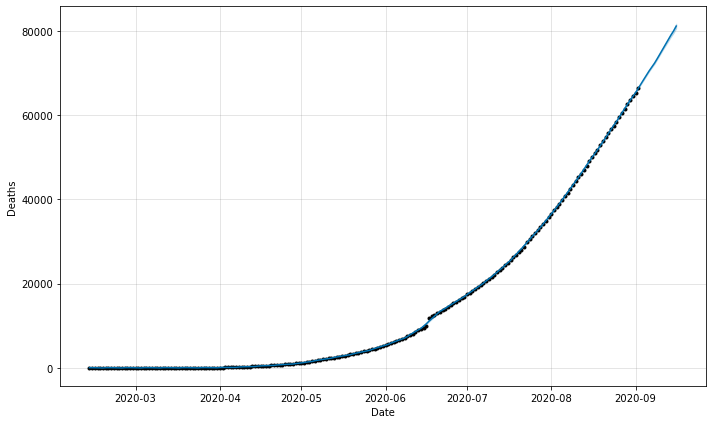

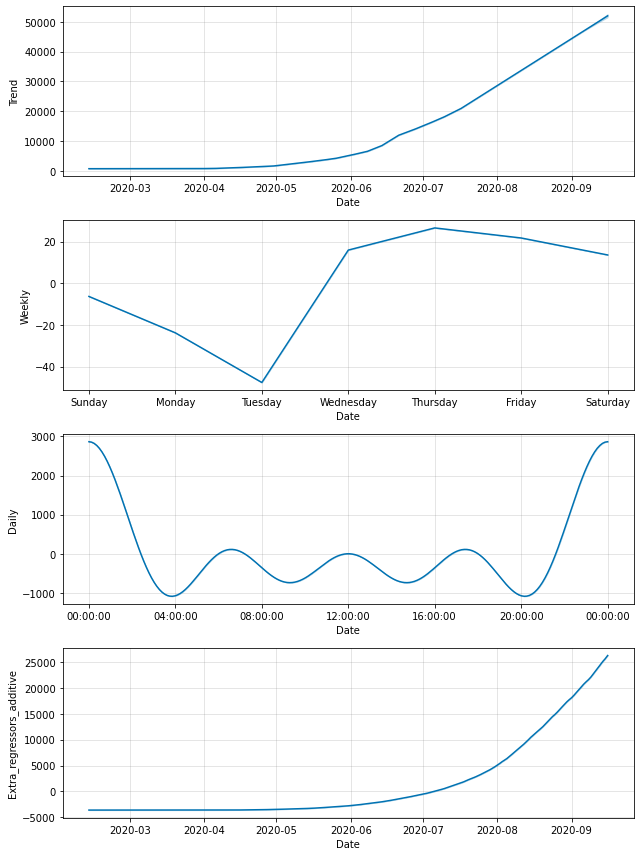

In [67]:

table="Yes"
graph="Yes"
regressor="Both"
forecasting(df_out,regressor,table,graph)